<a href="https://colab.research.google.com/github/Paradise2000/ProjectML/blob/main/III_etap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Wczytanie danych

In [2]:
import pandas as pd
import io
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.ensemble import RandomForestRegressor

pd.options.mode.chained_assignment = None

df = pd.read_csv("NY-House-Dataset.csv", delimiter=";", decimal=".")
display(df)

,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,Brokered by Douglas Elliman -111 Fifth Ave,Condo for sale,315000,2,2.000000,1400.000000,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483
1,Brokered by Serhant,Condo for sale,195000000,7,10.000000,17545.000000,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991
2,Brokered by Sowae Corp,House for sale,260000,4,2.000000,2015.000000,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109
3,Brokered by COMPASS,Condo for sale,69000,3,1.000000,445.000000,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613
4,Brokered by Sotheby's International Realty - E...,Townhouse for sale,55000000,7,2.373861,14175.000000,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4796,Brokered by COMPASS,Co-op for sale,599000,1,1.000000,2184.207862,222 E 80th St Apt 3A,"Manhattan, NY 10075","222 E 80th St Apt 3AManhattan, NY 10075",New York,New York County,New York,Manhattan,222,"222 E 80th St #3a, New York, NY 10075, USA",40.774350,-73.955879
4797,Brokered by Mjr Real Estate Llc,Co-op for sale,245000,1,1.000000,2184.207862,97-40 62 Dr Unit Lg,"Rego Park, NY 11374","97-40 62 Dr Unit LgRego Park, NY 11374",United States,New York,Queens County,Queens,62nd Drive,"97-40 62nd Dr, Rego Park, NY 11374, USA",40.732538,-73.860152
4798,Brokered by Douglas Elliman - 575 Madison Ave,Co-op for sale,1275000,1,1.000000,2184.207862,427 W 21st St Unit Garden,"New York, NY 10011","427 W 21st St Unit GardenNew York, NY 10011",United States,New York,New York County,New York,West 21st Street,"427 W 21st St, New York, NY 10011, USA",40.745882,-74.003398
4799,Brokered by E Realty International Corp,Condo for sale,598125,2,1.000000,655.000000,91-23 Corona Ave Unit 4G,"Elmhurst, NY 11373","91-23 Corona Ave Unit 4GElmhurst, NY 11373",New York,Queens County,Queens,Flushing,91-23,"91-23 Corona Ave. #4b, Flushing, NY 11373, USA",40.742770,-73.872752


Sprawdzenie czy są brakujące dane NaN. Analiza wykazała, że nie ma żadnych NaN

In [ ]:
print(df.isnull().sum())

BROKERTITLE                    0
TYPE                           0
PRICE                          0
BEDS                           0
BATH                           0
PROPERTYSQFT                   0
ADDRESS                        0
STATE                          0
MAIN_ADDRESS                   0
ADMINISTRATIVE_AREA_LEVEL_2    0
LOCALITY                       0
SUBLOCALITY                    0
STREET_NAME                    0
LONG_NAME                      0
FORMATTED_ADDRESS              0
LATITUDE                       0
LONGITUDE                      0
dtype: int64


Usuwanie outlierów. Wyliczenie średniej ceny za stopę kwadratową i wyeliminowanie tylko tych najdroższych luksusowych nieruchomości oraz tych najtańszych

In [3]:
df['PRICE_PER_SQFT'] = df['PRICE'] / df['PROPERTYSQFT']

Q1 = df['PRICE_PER_SQFT'].quantile(0.25)
Q3 = df['PRICE_PER_SQFT'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df[(df['PRICE_PER_SQFT'] >= lower_bound) & (df['PRICE_PER_SQFT'] <= upper_bound)]

print(f"Liczba z outlierami: {len(df)}")
print(f"Liczba bez outlierów: {len(df_filtered)}")

df = df_filtered

Liczba z outlierami: 4801
Liczba bez outlierów: 4345


Usuwanie duplikatów tych samych nieruchomości

In [4]:
before_removing_duplicates = len(df)
df.drop_duplicates(subset=["PRICE", "BEDS", "BATH", "PROPERTYSQFT", "ADDRESS"], keep="first", inplace=True)
print(f"Liczba usuniętych duplikatów  {before_removing_duplicates - len(df)}")

Liczba usuniętych duplikatów  192


Przypisanie liczb do kategorii z pomocą Label encoding

In [5]:
selected_columns = ["BROKERTITLE", "TYPE", "ADMINISTRATIVE_AREA_LEVEL_2", "LOCALITY", "SUBLOCALITY"]

encoder = LabelEncoder()

for kolumna in selected_columns:
    df[kolumna] = encoder.fit_transform(df[kolumna])

display(df)

,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE,PRICE_PER_SQFT
0,290,2,315000,2,2.0,1400.000000,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",26,4,9,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483,225.000000
2,909,7,260000,4,2.0,2015.000000,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",28,4,15,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109,129.032258
3,175,2,69000,3,1.0,445.000000,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",28,4,11,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613,155.056180
5,909,7,690000,5,2.0,4004.000000,584 Park Pl,"Brooklyn, NY 11238","584 Park PlBrooklyn, NY 11238",28,4,8,Brooklyn,Park Place,"584 Park Pl, Brooklyn, NY 11238, USA",40.674363,-73.958725,172.327672
6,301,2,899500,2,2.0,2184.207862,157 W 126th St Unit 1B,"New York, NY 10027","157 W 126th St Unit 1BNew York, NY 10027",25,5,10,Manhattan,157,"157 W 126th St #1b, New York, NY 10027, USA",40.809448,-73.946777,411.819779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4796,175,0,599000,1,1.0,2184.207862,222 E 80th St Apt 3A,"Manhattan, NY 10075","222 E 80th St Apt 3AManhattan, NY 10075",25,5,10,Manhattan,222,"222 E 80th St #3a, New York, NY 10075, USA",40.774350,-73.955879,274.241298
4797,647,0,245000,1,1.0,2184.207862,97-40 62 Dr Unit Lg,"Rego Park, NY 11374","97-40 62 Dr Unit LgRego Park, NY 11374",28,4,13,Queens,62nd Drive,"97-40 62nd Dr, Rego Park, NY 11374, USA",40.732538,-73.860152,112.168812
4798,301,0,1275000,1,1.0,2184.207862,427 W 21st St Unit Garden,"New York, NY 10011","427 W 21st St Unit GardenNew York, NY 10011",28,4,11,New York,West 21st Street,"427 W 21st St, New York, NY 10011, USA",40.745882,-74.003398,583.735652
4799,328,2,598125,2,1.0,655.000000,91-23 Corona Ave Unit 4G,"Elmhurst, NY 11373","91-23 Corona Ave Unit 4GElmhurst, NY 11373",25,7,12,Flushing,91-23,"91-23 Corona Ave. #4b, Flushing, NY 11373, USA",40.742770,-73.872752,913.167939


Przeprowadzenie Min-max scaling na danych numerycznych

In [6]:
numeric_columns = ["PRICE", "BEDS", "BATH", "PROPERTYSQFT"]

prices_before_min_max = df["PRICE"].copy()

scaler = MinMaxScaler()

df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

price_scaler = MinMaxScaler()
price_scaler.fit(prices_before_min_max.values.reshape(-1, 1))

display(df)

,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE,PRICE_PER_SQFT
0,290,2,0.009922,0.020408,0.04,0.017916,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",26,4,9,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483,225.000000
2,909,7,0.008175,0.061224,0.04,0.027333,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",28,4,15,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109,129.032258
3,175,2,0.002111,0.040816,0.02,0.003292,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",28,4,11,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613,155.056180
5,909,7,0.021827,0.081633,0.04,0.057790,584 Park Pl,"Brooklyn, NY 11238","584 Park PlBrooklyn, NY 11238",28,4,8,Brooklyn,Park Place,"584 Park Pl, Brooklyn, NY 11238, USA",40.674363,-73.958725,172.327672
6,301,2,0.028479,0.020408,0.04,0.029924,157 W 126th St Unit 1B,"New York, NY 10027","157 W 126th St Unit 1BNew York, NY 10027",25,5,10,Manhattan,157,"157 W 126th St #1b, New York, NY 10027, USA",40.809448,-73.946777,411.819779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4796,175,0,0.018938,0.000000,0.02,0.029924,222 E 80th St Apt 3A,"Manhattan, NY 10075","222 E 80th St Apt 3AManhattan, NY 10075",25,5,10,Manhattan,222,"222 E 80th St #3a, New York, NY 10075, USA",40.774350,-73.955879,274.241298
4797,647,0,0.007699,0.000000,0.02,0.029924,97-40 62 Dr Unit Lg,"Rego Park, NY 11374","97-40 62 Dr Unit LgRego Park, NY 11374",28,4,13,Queens,62nd Drive,"97-40 62nd Dr, Rego Park, NY 11374, USA",40.732538,-73.860152,112.168812
4798,301,0,0.040400,0.000000,0.02,0.029924,427 W 21st St Unit Garden,"New York, NY 10011","427 W 21st St Unit GardenNew York, NY 10011",28,4,11,New York,West 21st Street,"427 W 21st St, New York, NY 10011, USA",40.745882,-74.003398,583.735652
4799,328,2,0.018910,0.020408,0.02,0.006508,91-23 Corona Ave Unit 4G,"Elmhurst, NY 11373","91-23 Corona Ave Unit 4GElmhurst, NY 11373",25,7,12,Flushing,91-23,"91-23 Corona Ave. #4b, Flushing, NY 11373, USA",40.742770,-73.872752,913.167939


**Do zrobienia**
1. Redukcja wymiarowości
2. Podział na zbiory treningowe i testowe

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4153 entries, 0 to 4800
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BROKERTITLE                  4153 non-null   int64  
 1   TYPE                         4153 non-null   int64  
 2   PRICE                        4153 non-null   float64
 3   BEDS                         4153 non-null   float64
 4   BATH                         4153 non-null   float64
 5   PROPERTYSQFT                 4153 non-null   float64
 6   ADDRESS                      4153 non-null   object 
 7   STATE                        4153 non-null   object 
 8   MAIN_ADDRESS                 4153 non-null   object 
 9   ADMINISTRATIVE_AREA_LEVEL_2  4153 non-null   int64  
 10  LOCALITY                     4153 non-null   int64  
 11  SUBLOCALITY                  4153 non-null   int64  
 12  STREET_NAME                  4153 non-null   object 
 13  LONG_NAME              

In [7]:
df.drop(columns=["ADDRESS","STATE","MAIN_ADDRESS","STREET_NAME","LONG_NAME","FORMATTED_ADDRESS"], inplace=True)

In [8]:
pca = PCA(n_components=0.95)
df_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(data = df_pca)
print(f"Liczba komponentów PCA: {df_pca.shape[1]}")
display(df_pca)

X = df_pca
y = df['PRICE']
y_before_min_max = prices_before_min_max

X_train, X_test, y_train, y_test, y_train_before_min_max, y_test_before_min_max = train_test_split(
    X, y, y_before_min_max, test_size=0.2, random_state=42
)


print(f"Rozmiar zbioru treningowego: {X_train.shape}")
print(f"Rozmiar zbioru testowego: {X_test.shape}")

Liczba komponentów PCA: 2


,0,1
0,-205.239635,-297.522407
1,-548.006915,226.784043
2,-221.522885,-431.132875
3,-508.552468,244.642617
4,-39.594286,-210.440002
...,...,...
4148,-112.949022,-381.974595
4149,-455.295025,-18.854885
4150,117.009775,-139.526975
4151,405.970451,20.959930


Rozmiar zbioru treningowego: (3322, 2)
Rozmiar zbioru testowego: (831, 2)


Sprawdzenie Korelacji danych

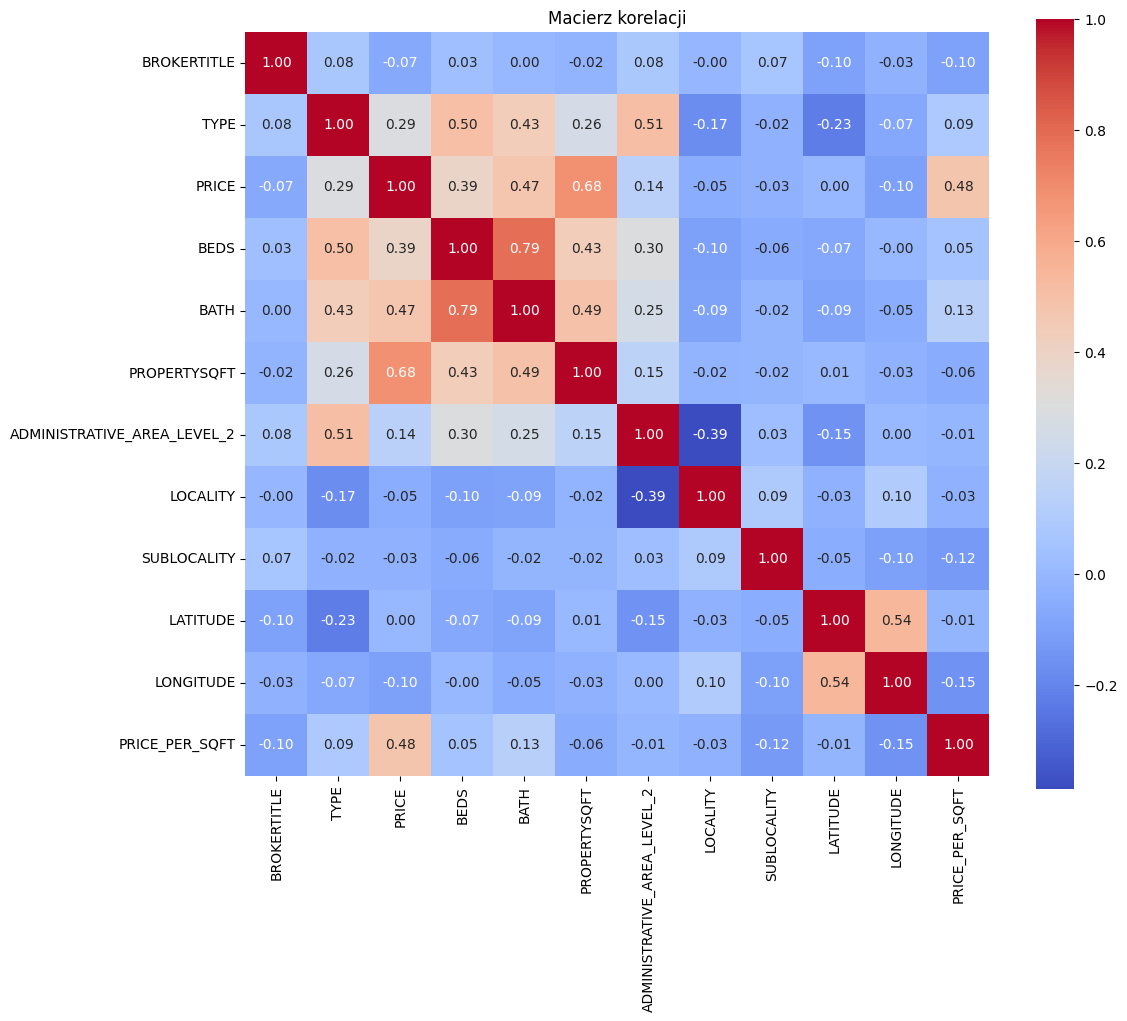

In [ ]:
correlation_matrix = df.select_dtypes(include=np.number).corr()

plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Macierz korelacji")
plt.show()

#Projekt - Etap II

1. Stworzenie podstawowego modelu regresji liniowej.
2. Przygotowanie wizualizacji porównującej ceny predykcyjne z cenami rzeczywistymi.

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

print(f"Średni błąd kwadratowy (MSE): {mse:.4f}")
print(f"Średni błąd absolutny (MAE): {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Wynik wyjaśnionej wariancji (EVS): {evs:.4f}")

Średni błąd kwadratowy (MSE): 0.0007
Średni błąd absolutny (MAE): 0.0142
R^2 Score: 0.2708
Wynik wyjaśnionej wariancji (EVS): 0.2752


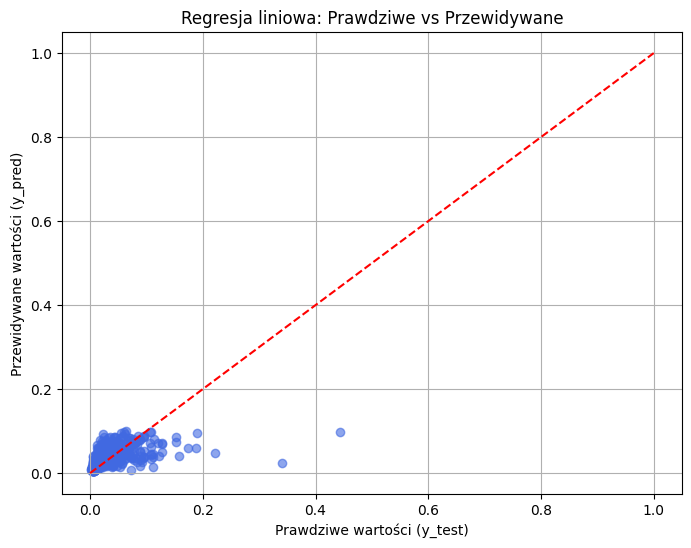

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='royalblue')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Prawdziwe wartości (y_test)')
plt.ylabel('Przewidywane wartości (y_pred)')
plt.title('Regresja liniowa: Prawdziwe vs Przewidywane')
plt.grid(True)
plt.show()

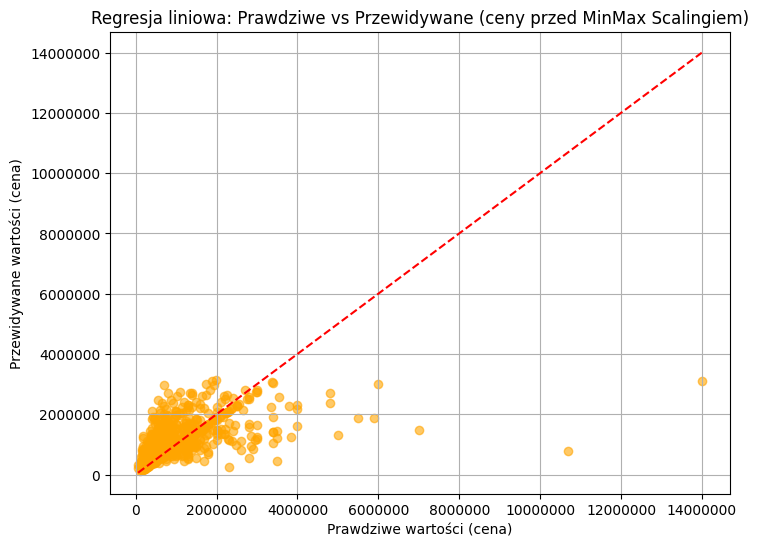

In [ ]:
y_pred_before_min_max = price_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

plt.figure(figsize=(8,6))
plt.scatter(y_test_before_min_max, y_pred_before_min_max, alpha=0.6, color='orange')
plt.plot([min(y_test_before_min_max), max(y_test_before_min_max)],
         [min(y_test_before_min_max), max(y_test_before_min_max)], 'r--')
plt.xlabel('Prawdziwe wartości (cena)')
plt.ylabel('Przewidywane wartości (cena)')
plt.title('Regresja liniowa: Prawdziwe vs Przewidywane (ceny przed MinMax Scalingiem)')
plt.grid(True)

plt.ticklabel_format(style='plain', axis='both')

plt.show()

# III etap

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
evs_rf = explained_variance_score(y_test, y_pred_rf)

print("Wyniki modelu Random Forest:")
print(f"Mean Squared Error (MSE): {mse_rf:.4f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.4f}")
print(f"R^2 Score: {r2_rf:.4f}")
print(f"Explained Variance Score (EVS): {evs_rf:.4f}")

Wyniki modelu Random Forest:
Mean Squared Error (MSE): 0.0010
Mean Absolute Error (MAE): 0.0167
R^2 Score: 0.0618
Explained Variance Score (EVS): 0.0666


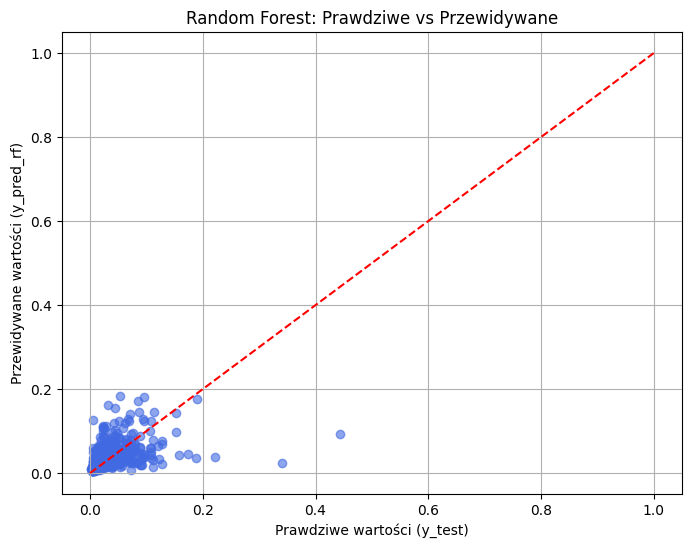

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='royalblue')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Prawdziwe wartości (y_test)')
plt.ylabel('Przewidywane wartości (y_pred_rf)')
plt.title('Random Forest: Prawdziwe vs Przewidywane')
plt.grid(True)
plt.show()

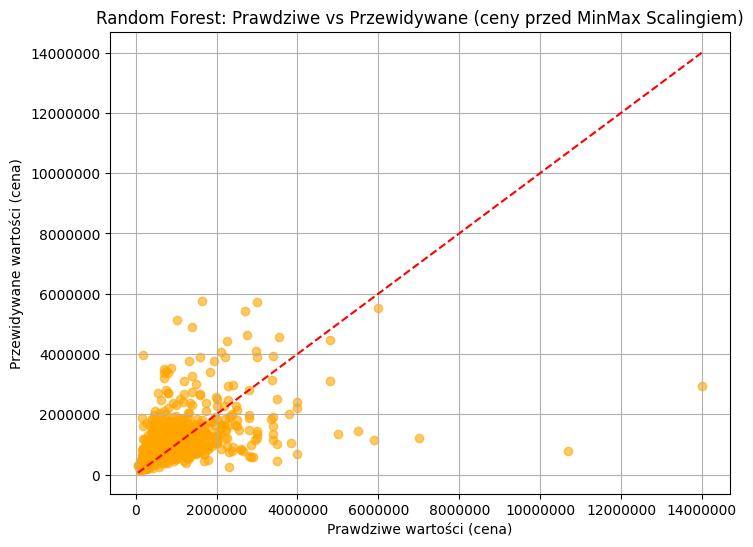

In [ ]:
y_pred_tree_before_min_max = price_scaler.inverse_transform(y_pred_rf.reshape(-1, 1)).flatten()

plt.figure(figsize=(8,6))
plt.scatter(y_test_before_min_max, y_pred_tree_before_min_max, alpha=0.6, color='orange')
plt.plot([min(y_test_before_min_max), max(y_test_before_min_max)],
         [min(y_test_before_min_max), max(y_test_before_min_max)], 'r--')

plt.xlabel('Prawdziwe wartości (cena)')
plt.ylabel('Przewidywane wartości (cena)')
plt.title('Random Forest: Prawdziwe vs Przewidywane (ceny przed MinMax Scalingiem)')
plt.grid(True)

plt.ticklabel_format(style='plain', axis='both')  # usuwa notację naukową

plt.show()

Decision Tree Regressor Metrics:
Średni błąd kwadratowy (MSE): 0.0008
Średni błąd absolutny (MAE): 0.0155
R^2 Score: 0.1701
Wynik wyjaśnionej wariancji (EVS): 0.1715


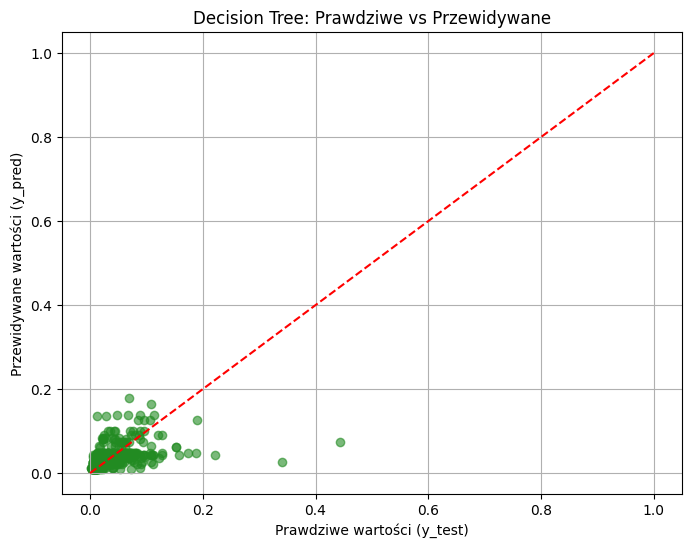

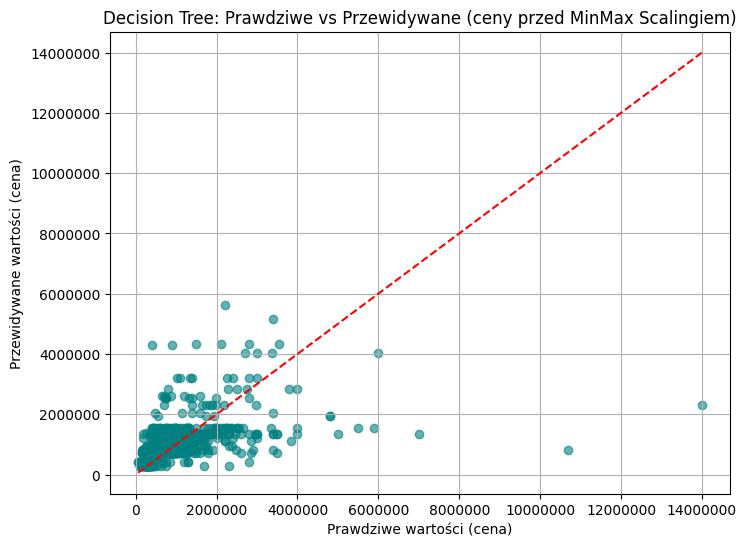

In [9]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
evs_dt = explained_variance_score(y_test, y_pred_dt)

print("Decision Tree Regressor Metrics:")
print(f"Średni błąd kwadratowy (MSE): {mse_dt:.4f}")
print(f"Średni błąd absolutny (MAE): {mae_dt:.4f}")
print(f"R^2 Score: {r2_dt:.4f}")
print(f"Wynik wyjaśnionej wariancji (EVS): {evs_dt:.4f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_dt, alpha=0.6, color='forestgreen')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Prawdziwe wartości (y_test)')
plt.ylabel('Przewidywane wartości (y_pred)')
plt.title('Decision Tree: Prawdziwe vs Przewidywane')
plt.grid(True)
plt.show()


y_pred_dt_before_min_max = price_scaler.inverse_transform(y_pred_dt.reshape(-1, 1)).flatten()

plt.figure(figsize=(8,6))
plt.scatter(y_test_before_min_max, y_pred_dt_before_min_max, alpha=0.6, color='teal')
plt.plot([min(y_test_before_min_max), max(y_test_before_min_max)],
         [min(y_test_before_min_max), max(y_test_before_min_max)], 'r--')
plt.xlabel('Prawdziwe wartości (cena)')
plt.ylabel('Przewidywane wartości (cena)')
plt.title('Decision Tree: Prawdziwe vs Przewidywane (ceny przed MinMax Scalingiem)')
plt.grid(True)

plt.ticklabel_format(style='plain', axis='both')

plt.show()